In [1]:
# Thanks to Jonathan Mulholland and Aaron Sander from Booz Allen Hamilton
# who made this code public as a part of the Kaggle Data Science Bowl 2017 contest.
# https://www.kaggle.com/c/data-science-bowl-2017/details/tutorial

import SimpleITK as sitk
import numpy as np
import os
from glob import glob
import pandas as pd

from tqdm import tqdm 

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def make_mask(center,diam,z,
              width,height, depth, 
              spacing, origin,  
              mask_width=32, mask_height=32, mask_depth=32):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    padMask = 5
    
    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+padMask)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-padMask])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+padMask])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-padMask]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+padMask])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # SPHERICAL MASK
    # Fill in 1 within sphere around nodule 
#     for v_x in v_xrange:
#         for v_y in v_yrange:
#             p_x = spacing[0]*v_x + origin[0]
#             p_y = spacing[1]*v_y + origin[1]
#             if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
#                 mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
               
    # RECTANGULAR MASK
    for v_x in v_xrange:
        for v_y in v_yrange:
            
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            
            if ((p_x >= (center[0] - mask_width)) &
                (p_x <= (center[0] + mask_width)) & 
                (p_y >= (center[1] - mask_height)) &
                (p_y <= (center[1] + mask_height))):
                
                mask[int((np.abs(p_y-origin[1]))/spacing[1]),int((np.abs(p_x-origin[0]))/spacing[0])] = 1.0
            
    
    # TODO:  The height and width seemed to be switched. 
    # This works but needs to be simplified. It's probably due to SimpleITK versus Numpy transposed indicies.
    left = np.max([0, np.abs(center[0] - origin[0]) - mask_width]).astype(int)
    right = np.min([width, np.abs(center[0] - origin[0]) + mask_width]).astype(int)
    down = np.max([0, np.abs(center[1] - origin[1]) - mask_height]).astype(int)
    up = np.min([height, np.abs(center[1] - origin[1]) + mask_height]).astype(int)
    
    top = np.min([depth, np.abs(center[2] - origin[2]) + mask_depth]).astype(int)
    bottom = np.max([0, np.abs(center[2] - origin[2]) - mask_depth]).astype(int)
    
    bbox = [[down, up], [left, right], [bottom, top]]
    
    return mask, bbox

In [3]:
############
#
# Getting list of image files
luna_path = "/media/tony/TOSHIBA EXT/luna/" 
luna_subset_path = luna_path + 'subset0/'
output_path = "./"
file_list=glob(luna_subset_path+"*.mhd")

In [4]:
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"candidates_V2.csv")


In [5]:
df_node.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [6]:
"""
Normalize pixel depth into Hounsfield units (HU)
This tries to get all pixels between -1000 and 400 HU.
All other HU will be masked.
Then we normalize pixel values between 0 and 1.
"""
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [7]:
def normalize_img(img):
    
    '''
    Sets the MHD image to be approximately 1.0 mm voxel size
    
    https://itk.org/ITKExamples/src/Filtering/ImageGrid/ResampleAnImage/Documentation.html
    '''
    new_x_size = int(img.GetSpacing()[0]*img.GetWidth())  # Number of pixels you want for x dimension
    new_y_size = int(img.GetSpacing()[1]*img.GetHeight()) # Number of pixels you want for y dimension
    new_z_size = int(img.GetSpacing()[2]*img.GetDepth())  # Number of pixels you want for z dimesion
    new_size = [new_x_size, new_y_size, new_z_size]
    
#     new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(img.GetSize(), img.GetSpacing(), new_size)]

    new_spacing = [1,1,1]  # New spacing to be 1.0 x 1.0 x 1.0 mm voxel size
    interpolator_type = sitk.sitkLinear

    return sitk.Resample(img, np.array(new_size, dtype='uint32').tolist(), sitk.Transform(), interpolator_type, img.GetOrigin(), new_spacing, img.GetDirection(), 0.0, img.GetPixelIDValue())
    

  0%|          | 0/89 [00:00<?, ?it/s]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
Class = 1


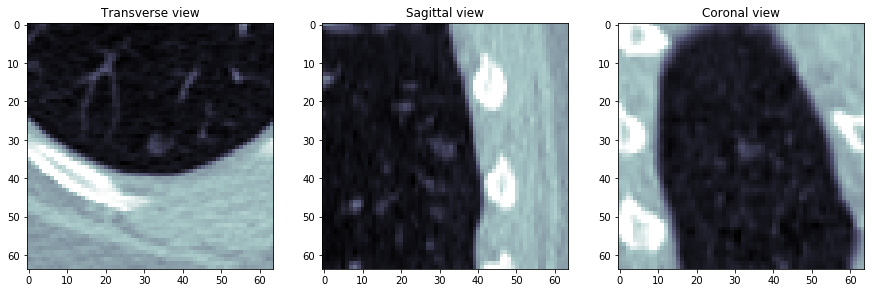

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
Class = 1


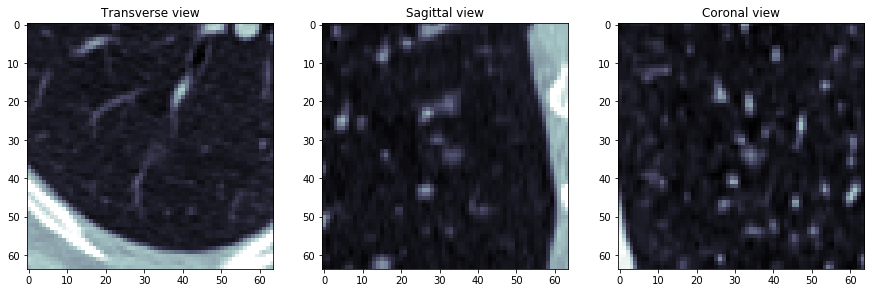

  2%|▏         | 2/89 [00:39<28:42, 19.79s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Class = 1


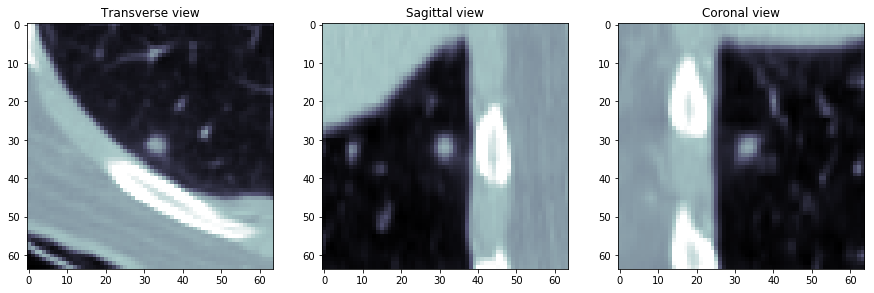

  3%|▎         | 3/89 [01:16<36:19, 25.35s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Class = 1


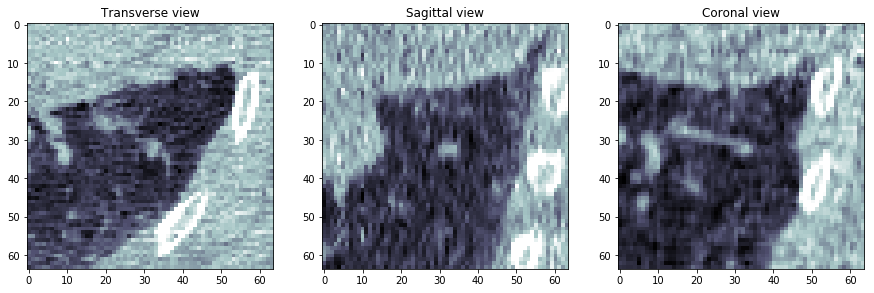

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Class = 1


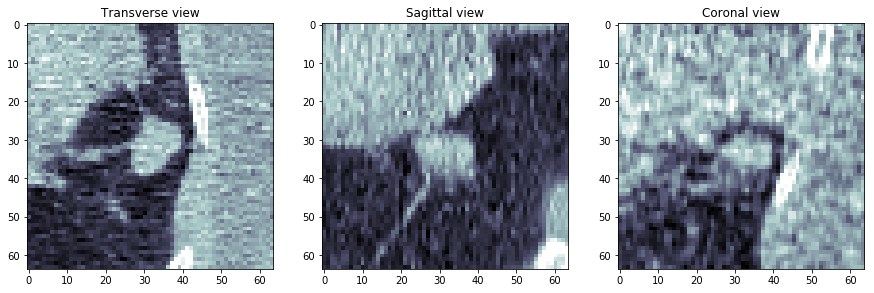

  4%|▍         | 4/89 [01:38<34:50, 24.60s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Class = 1


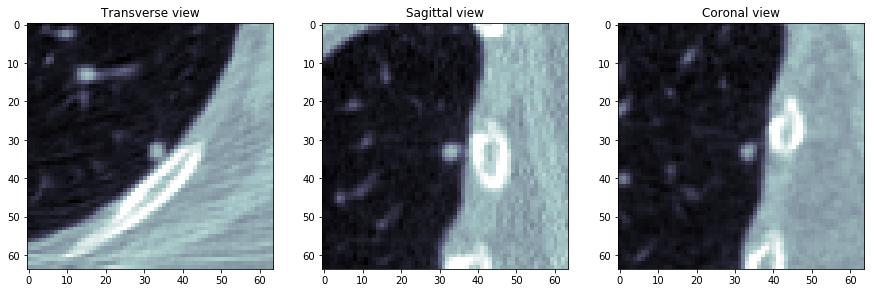

  6%|▌         | 5/89 [02:00<33:50, 24.17s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
Class = 1


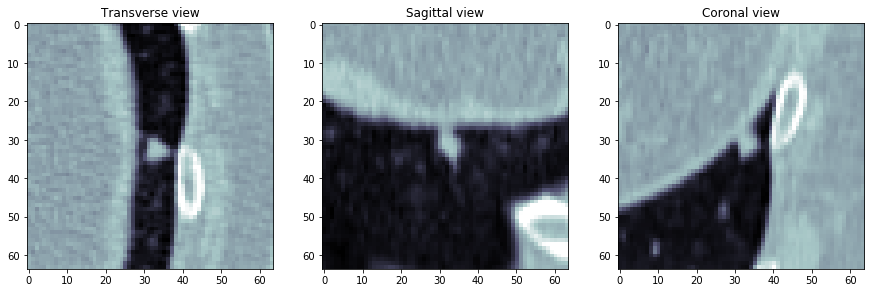

  8%|▊         | 7/89 [02:54<33:59, 24.87s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
Class = 1


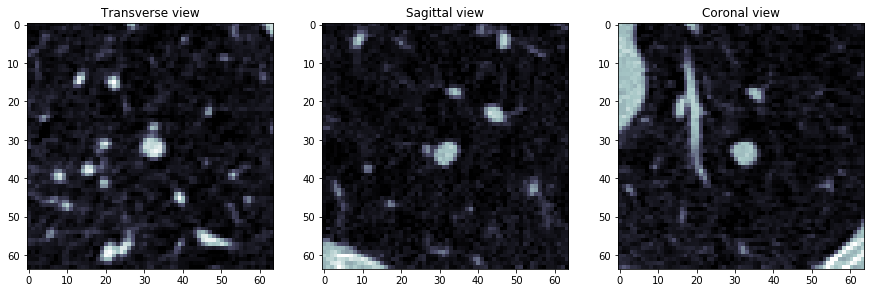

  9%|▉         | 8/89 [03:26<34:50, 25.81s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
Class = 1


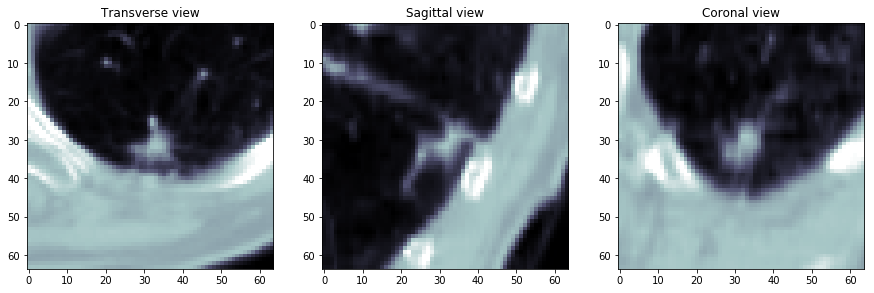

 10%|█         | 9/89 [03:55<34:56, 26.21s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
Class = 1


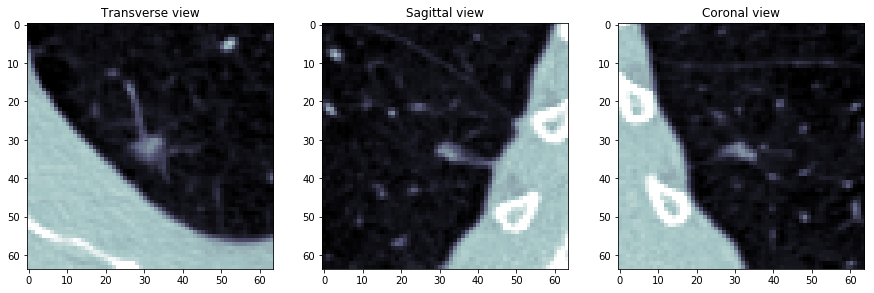

 11%|█         | 10/89 [04:25<34:58, 26.56s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd
Class = 1


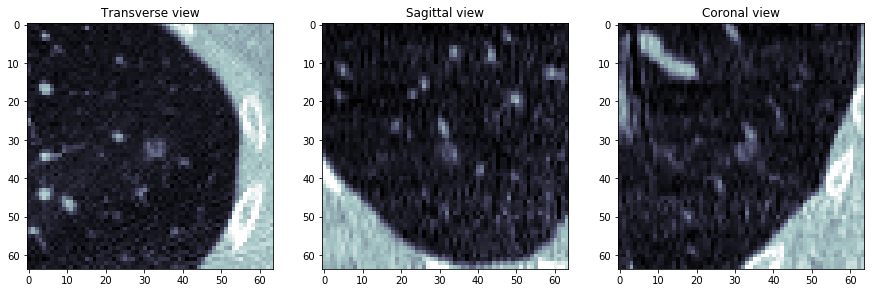

 12%|█▏        | 11/89 [05:03<35:50, 27.57s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
Class = 1


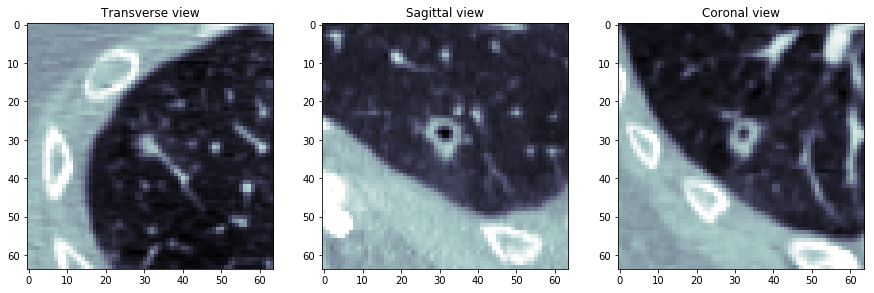

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
Class = 1


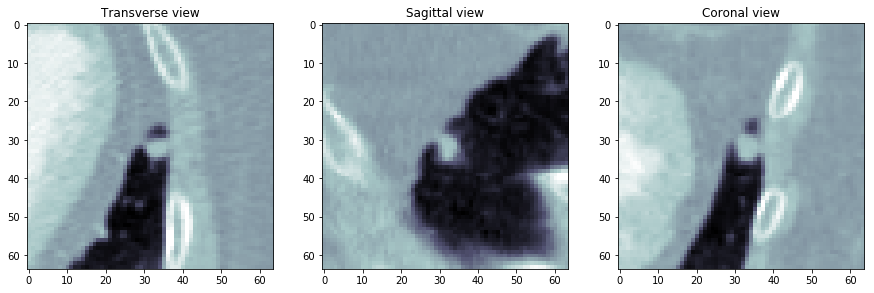

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
Class = 1


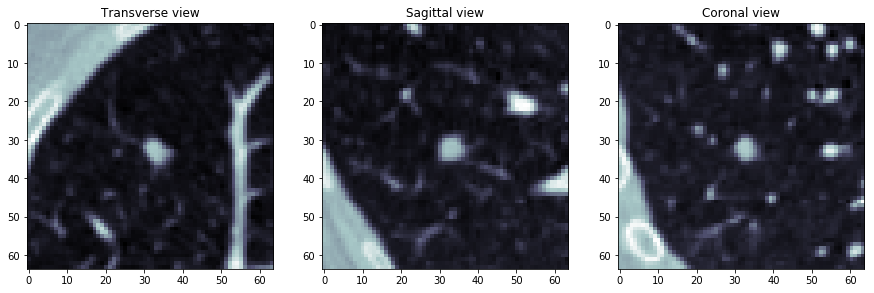

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
Class = 1


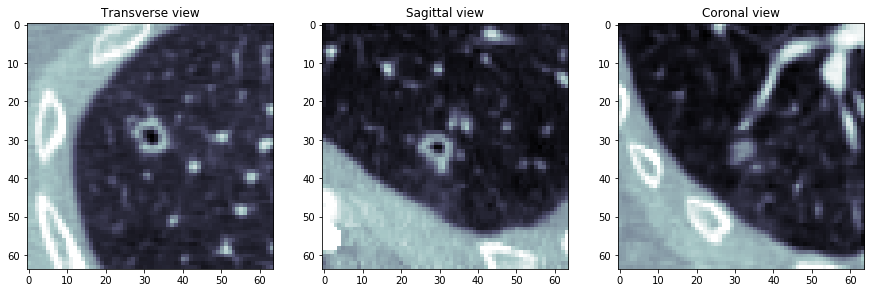

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
Class = 1


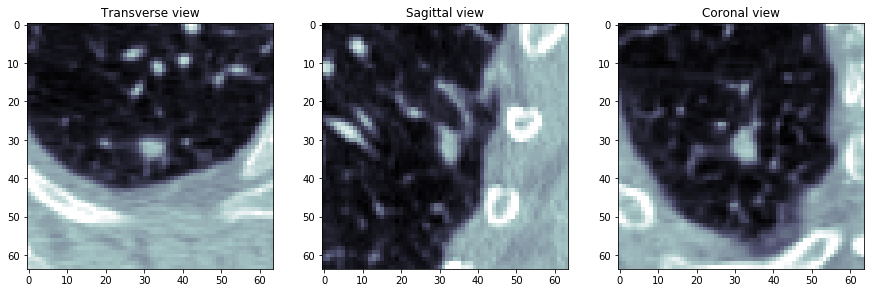

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
Class = 1


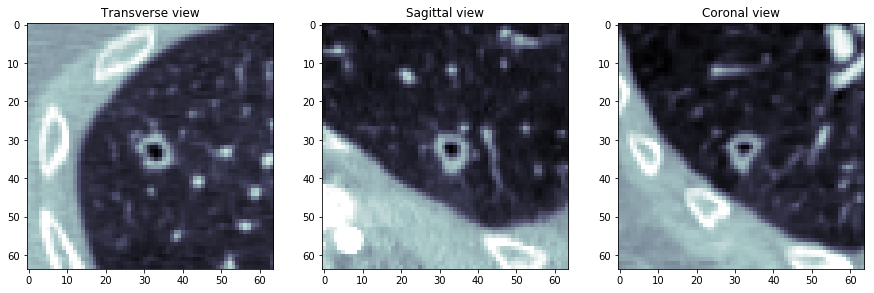

 13%|█▎        | 12/89 [05:32<35:34, 27.72s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
Class = 1


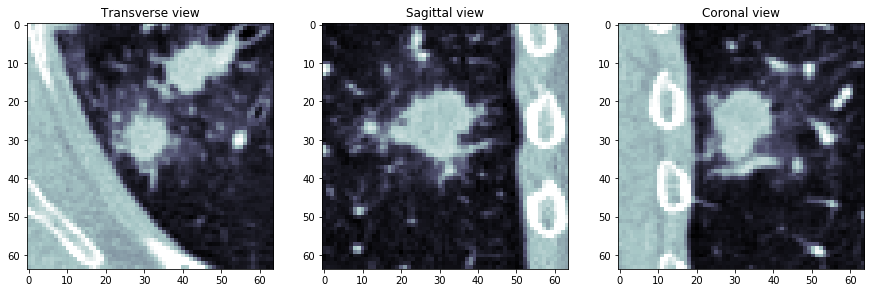

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
Class = 1


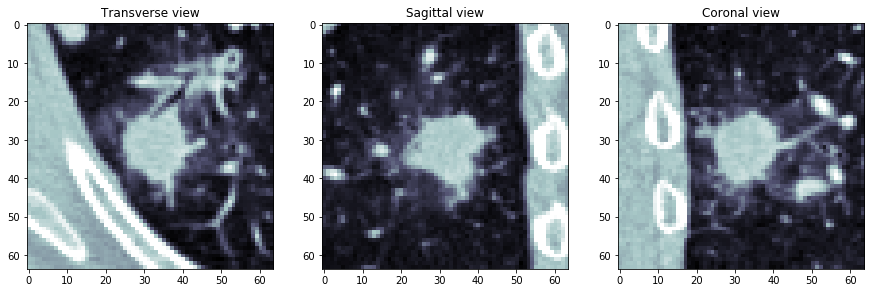

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
Class = 1


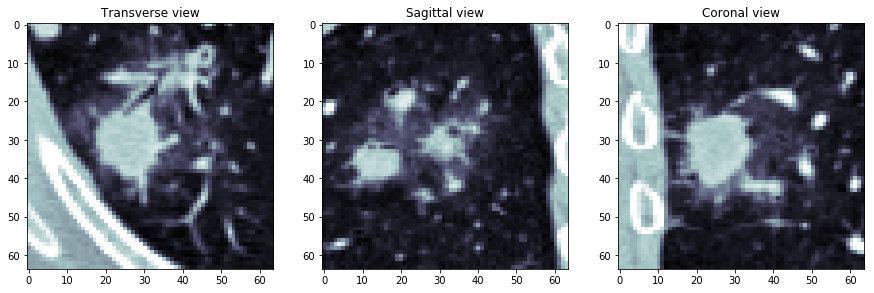

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
Class = 1


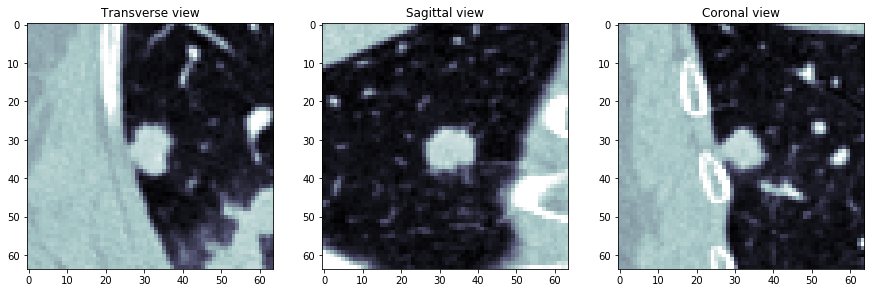

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
Class = 1


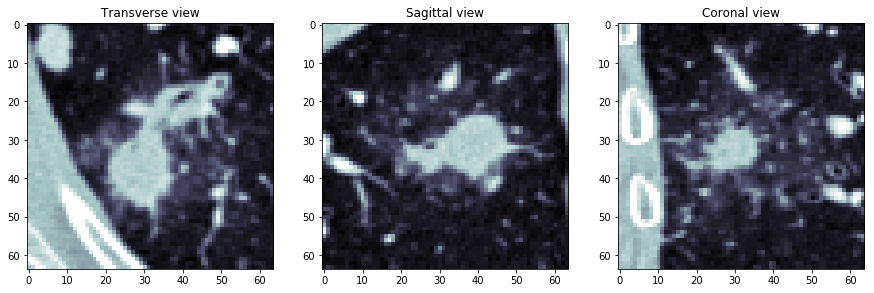

 16%|█▌        | 14/89 [06:16<33:36, 26.89s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
Class = 1


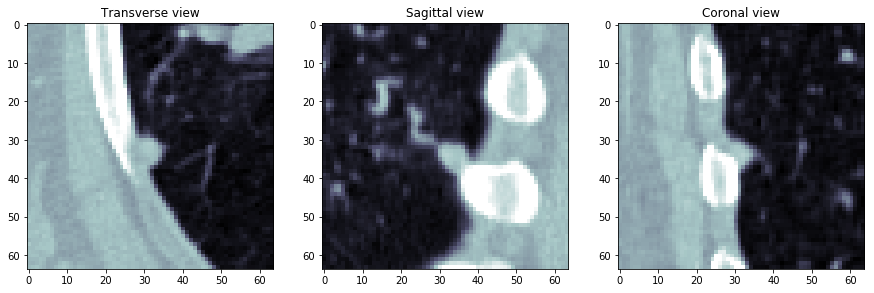

 17%|█▋        | 15/89 [06:46<33:23, 27.07s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
Class = 1


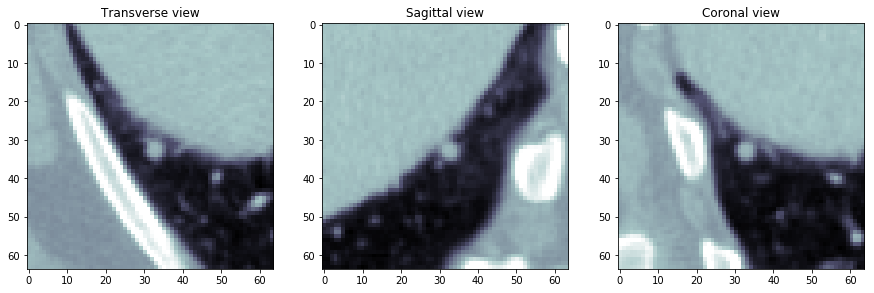

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
Class = 1


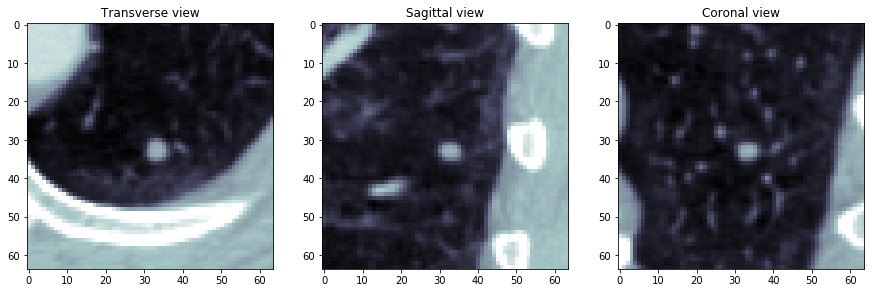

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
Class = 1


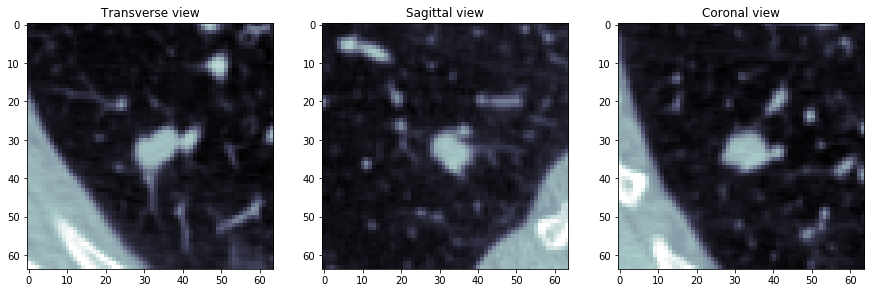

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
Class = 1


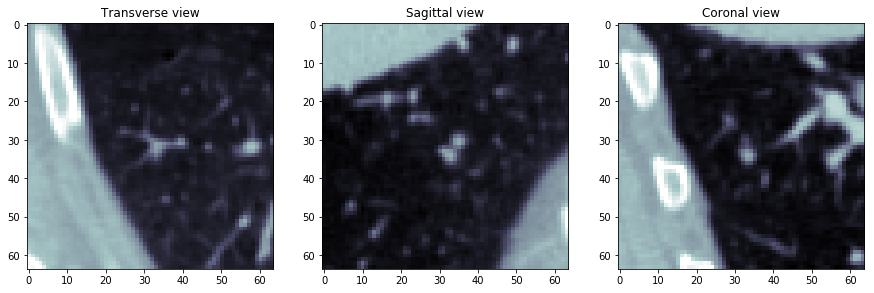

 18%|█▊        | 16/89 [07:13<32:59, 27.12s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
Class = 1


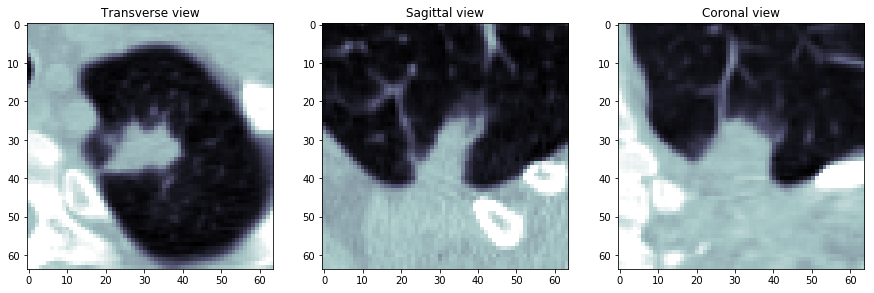

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
Class = 1


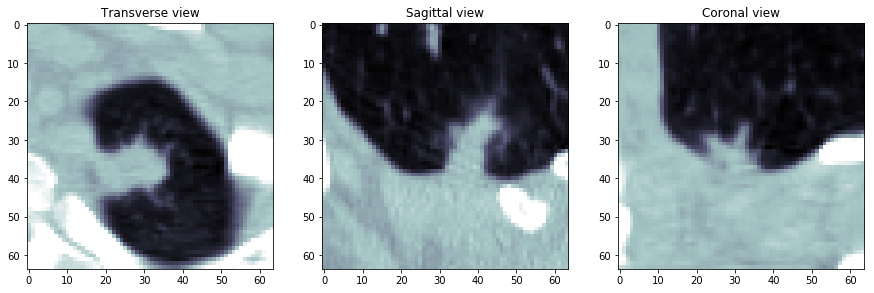

 19%|█▉        | 17/89 [07:28<31:41, 26.40s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd
Class = 1


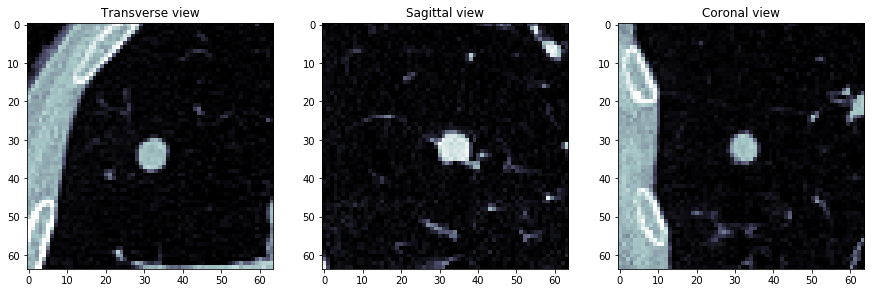

 21%|██▏       | 19/89 [08:28<31:11, 26.74s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
Class = 1


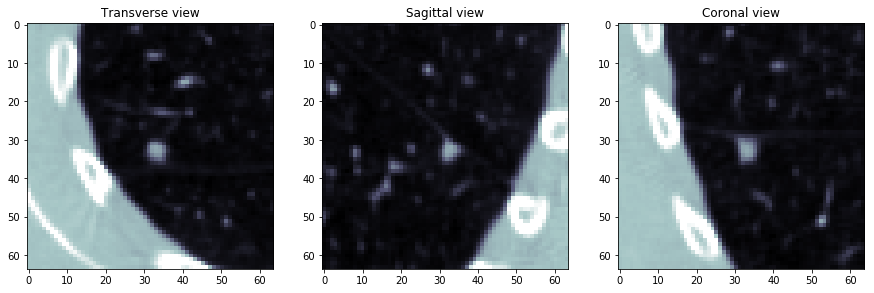

 25%|██▍       | 22/89 [09:33<29:06, 26.07s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd
Class = 1


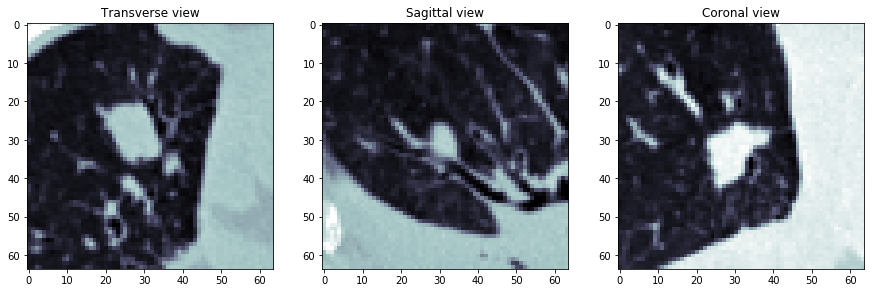

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd
Class = 1


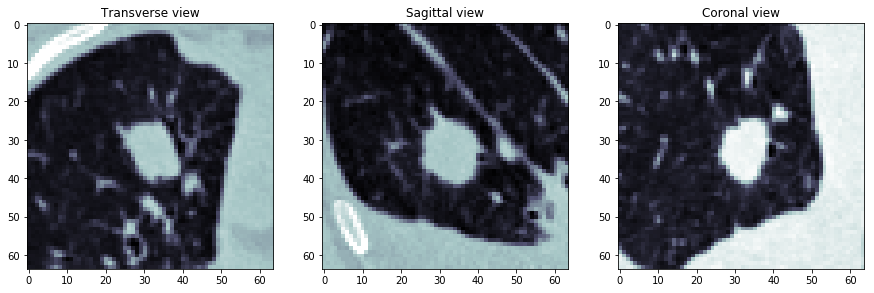

 26%|██▌       | 23/89 [09:51<28:18, 25.74s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
Class = 1


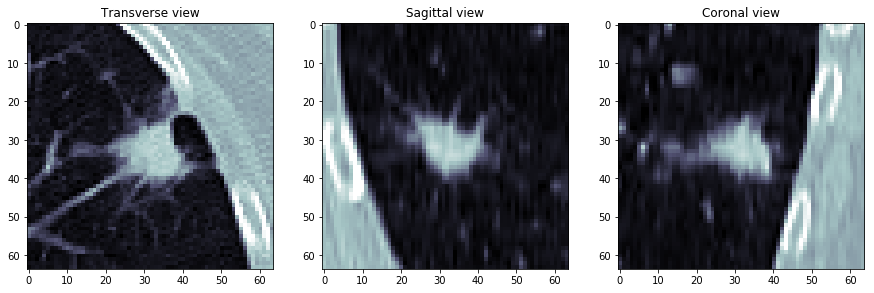

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
Class = 1


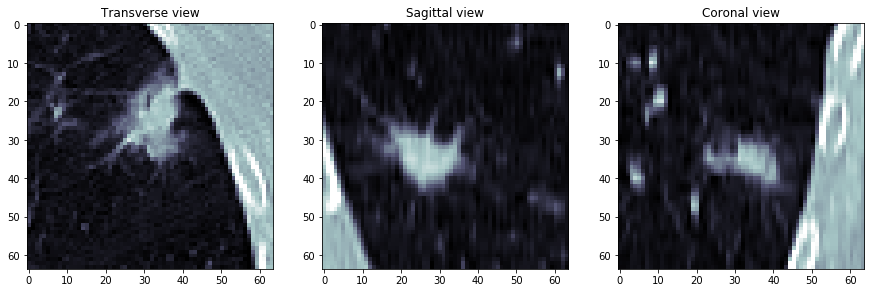

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
Class = 1


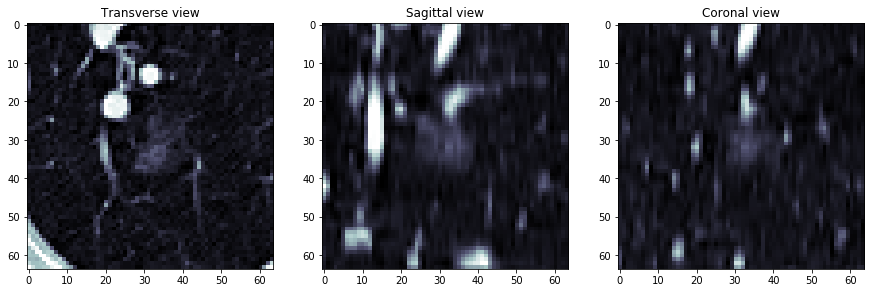

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
Class = 1


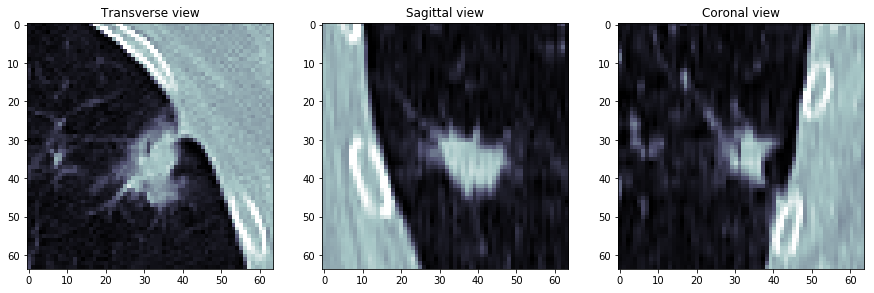

 27%|██▋       | 24/89 [10:13<27:40, 25.55s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd
Class = 1


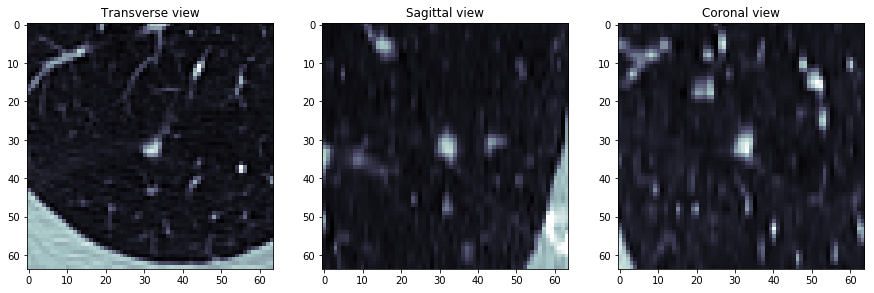

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd
Class = 1


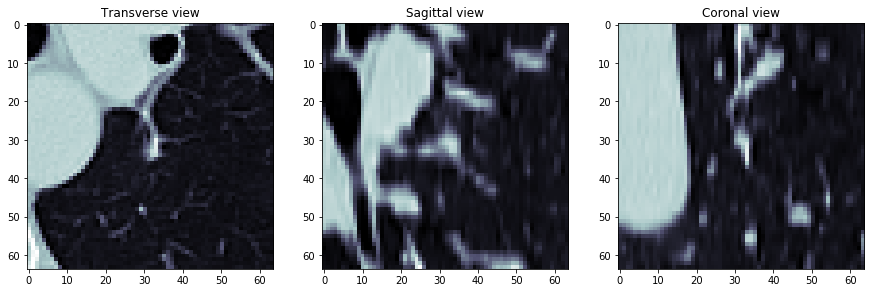

 28%|██▊       | 25/89 [10:38<27:13, 25.53s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
Class = 1


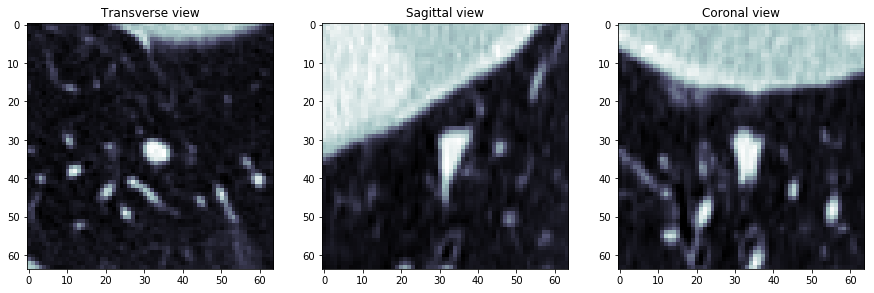

 30%|███       | 27/89 [11:17<25:55, 25.09s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
Class = 1


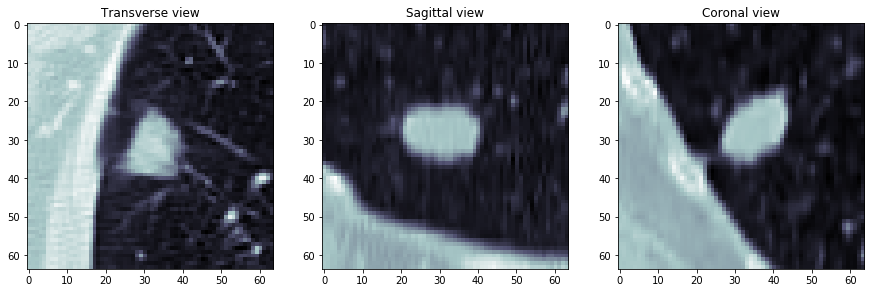

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
Class = 1


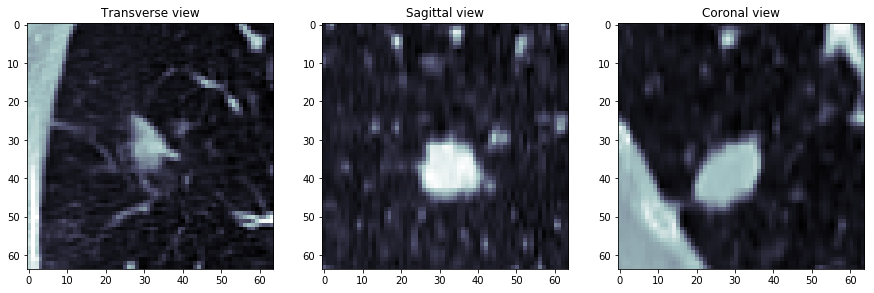

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
Class = 1


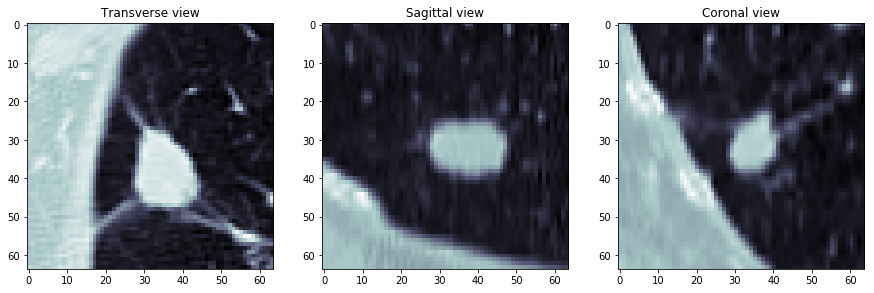

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
Class = 1


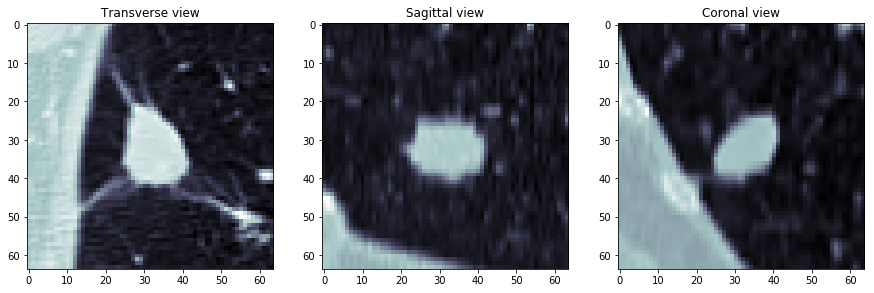

 33%|███▎      | 29/89 [12:06<25:03, 25.06s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd
Class = 1


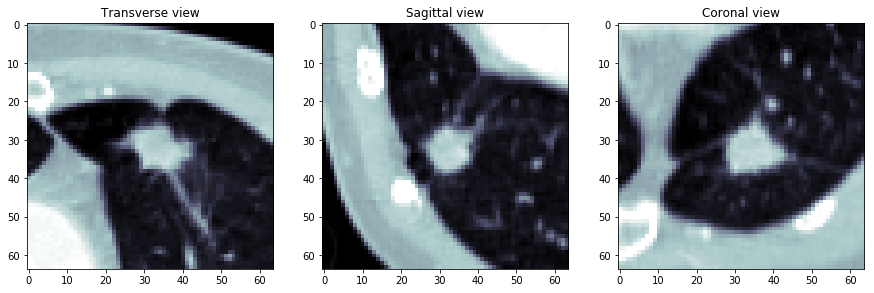

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd
Class = 1


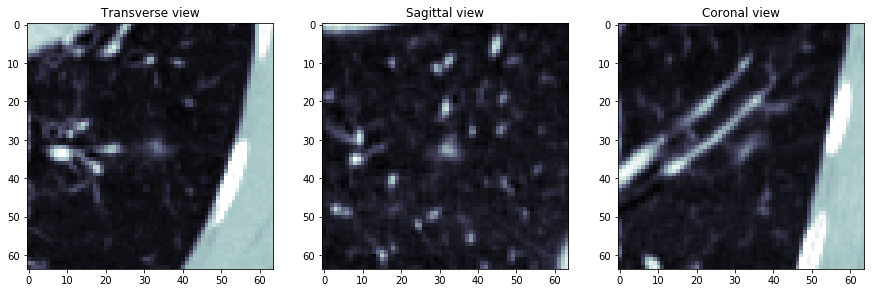

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd
Class = 1


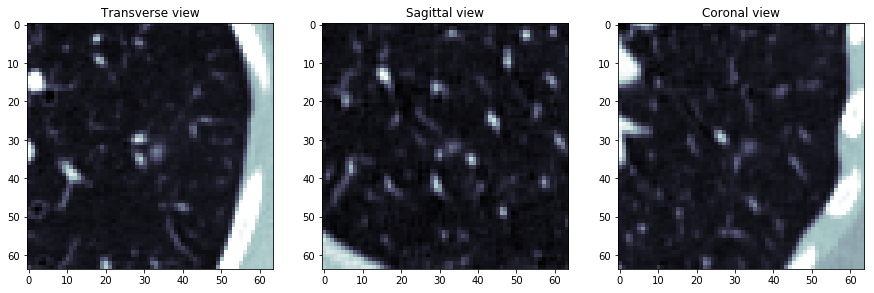

 34%|███▎      | 30/89 [12:33<24:41, 25.12s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd
Class = 1


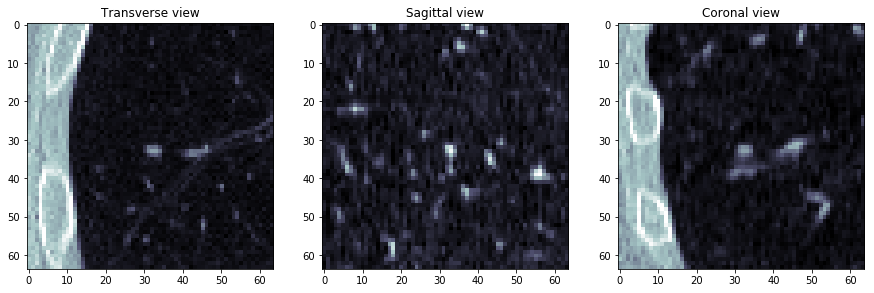

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd
Class = 1


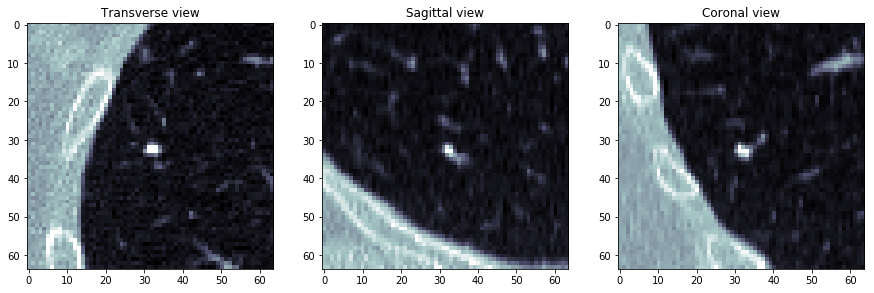

 35%|███▍      | 31/89 [12:56<24:13, 25.05s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
Class = 1


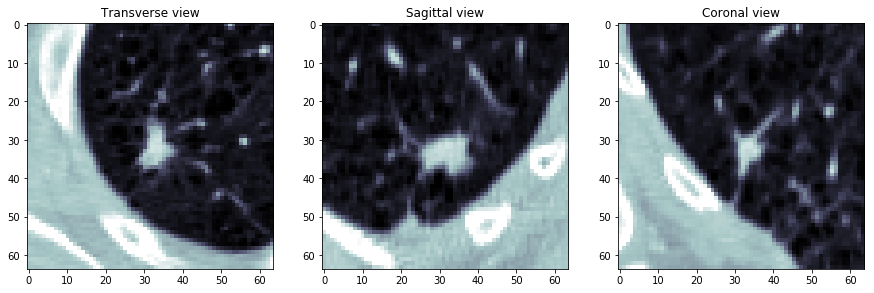

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
Class = 1


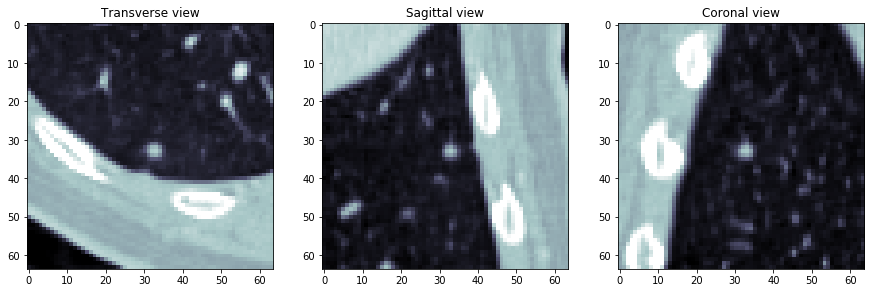

 36%|███▌      | 32/89 [13:26<23:57, 25.21s/it]

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
Class = 1


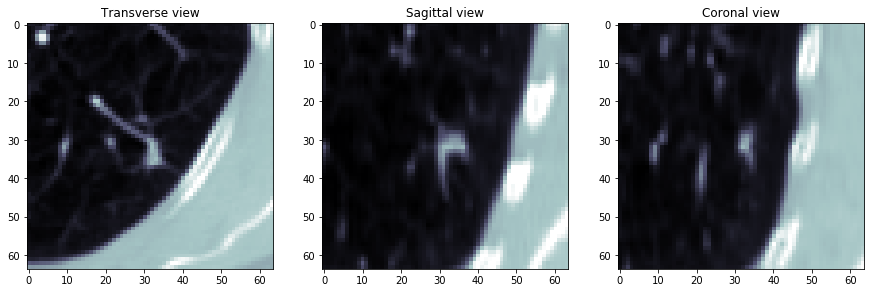

/media/tony/TOSHIBA EXT/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
Class = 1


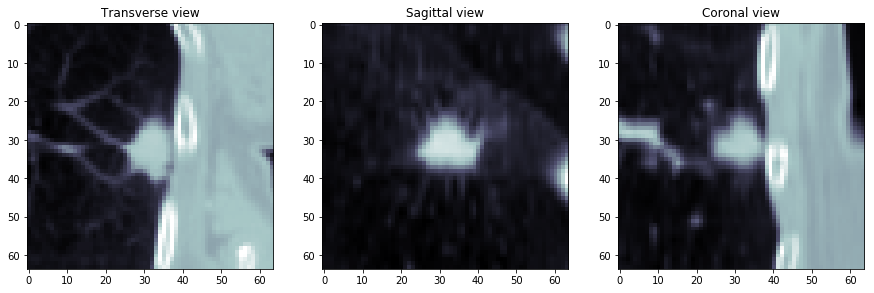

 38%|███▊      | 34/89 [14:16<23:05, 25.19s/it]

KeyboardInterrupt: 

In [8]:
#####
#
# Looping over the image files
#
import os

for fcount, img_file in enumerate(tqdm(file_list)):
    
    base=os.path.basename(img_file)  # Strip the filename out
    seriesuid = os.path.splitext(base)[0]  # Get the filename without the extension
    mini_df = df_node[df_node["seriesuid"] == seriesuid]
    
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        
        '''
        Extracts 2D patches from the 3 planes (transverse, coronal, and sagittal).
        
        The sticky point here is the order of the axes. Numpy is z,y,x and SimpleITK is x,y,z.
        I've found it very difficult to keep the order correct when going back and forth,
        but this code seems to pass the sanity checks.
        '''
        # Load the CT scan (3D .mhd file)
        itk_img = sitk.ReadImage(img_file)  # indices are x,y,z (note the ordering of dimesions)
        
        # Normalize the image spacing so that a voxel is 1x1x1 mm in dimension
        itk_img = normalize_img(itk_img)
       
        # SimpleITK keeps the origin and spacing information for the 3D image volume
        img_array = sitk.GetArrayFromImage(itk_img) # indices are z,y,x (note the ordering of dimesions)
        slice_z, height, width = img_array.shape        
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm) - Not same as img_array
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coordinates (mm)
        
        for candidate_idx, cur_row in mini_df.iterrows(): # Iterate through all candidates
            
            # This is the real world x,y,z coordinates of possible nodule (in mm)
            candidate_x = cur_row['coordX']
            candidate_y = cur_row['coordY']
            candidate_z = cur_row['coordZ']
            #diam = cur_row['diameter_mm']  # Only defined for true positives
            diam=30
            class_id = cur_row['class']
            
            mask_width = 32 # This is really the half width so window will be double this width
            mask_height = 32 # This is really the half height so window will be double this height
            mask_depth = 32 # This is really the half depth so window will be double this depth
            
            center = np.array([candidate_x, candidate_y, candidate_z])   # candidate center
            voxel_center = np.rint((center-origin)/spacing).astype(int)  # candidate center in voxel space (still x,y,z ordering)
            
            # Calculates the bounding box (and ROI mask) for desired position
            mask, bbox = make_mask(center, diam, voxel_center[2]*spacing[2]+origin[2],
                                   width, height, slice_z, spacing, origin, 
                                   mask_width, mask_height, mask_depth)
                
            # Transverse slice 2D view - Y-X plane
            # Confer with https://en.wikipedia.org/wiki/Anatomical_terms_of_location#Planes
            img_transverse = normalizePlanes(img_array[voxel_center[2], 
                                                       bbox[0][0]:bbox[0][1], 
                                                       bbox[1][0]:bbox[1][1]])
            
            # Sagittal slice 2D view - Z-Y plane
            img_sagittal = normalizePlanes(img_array[bbox[2][0]:bbox[2][1], 
                                                     bbox[0][0]:bbox[0][1], 
                                                     voxel_center[0]])
            
            # Coronal slice 2D view - Z-X plane
            img_coronal = normalizePlanes(img_array[bbox[2][0]:bbox[2][1], 
                                                    voxel_center[1], 
                                                    bbox[1][0]:bbox[1][1]])
               
            if (class_id == 1):
                print(img_file)
                print("Class = {}".format(class_id))
                plt.figure(figsize=(15,15))
                plt.subplot(1,3,1)
                plt.imshow(img_transverse, cmap='bone')
                plt.title('Transverse view')
                plt.subplot(1,3,2)
                plt.imshow(img_sagittal, cmap='bone')
                plt.title('Sagittal view')
                plt.subplot(1,3,3)
                plt.imshow(img_coronal, cmap='bone')
                plt.title('Coronal view')
                plt.show()
                

In [ ]:
print('Finished')